In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

2019                                                              \
         count      mean       std       min       25%       50%       75%   
type                                                                         
ПП    993852.0  0.046847  0.032400  0.000000  0.023278  0.034906  0.065542   
ТТ    648453.0  0.012086  0.040881 -0.602278  0.000171  0.013024  0.025730   

                    2020            ...                          2021  \
           max     count      mean  ...       75%       max     count   
type                                ...                                 
ПП    0.397476  993852.0  0.032920  ...  0.050842  0.115568  993852.0   
ТТ    0.429131  648453.0  0.008575  ...  0.020356  0.140210  648453.0   

                                                                            
          mean       std       min       25%       50%       75%       max  
type                                                                        
ПП    0.028993  0.022057  0.000000  0.012658  0.024063  0.041023  0.205782  
ТТ    0.019538  0.025661 -0.385017  0.002746  0.012579  0.038769  0.193013  

[2 rows x 24 columns]

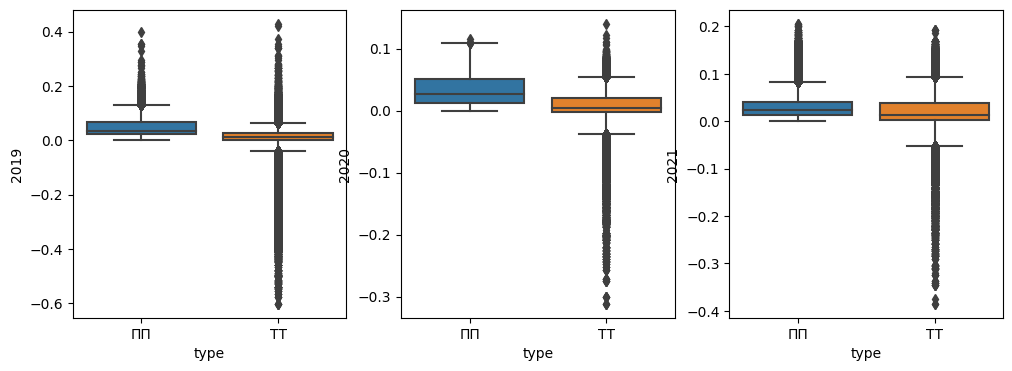

In [2]:
archangelskoe = gpd.read_file('vector_data/archangelskoe.geojson')
archangelskoe = archangelskoe.to_crs("EPSG:32638")
dobrovolnoe = gpd.read_file('vector_data/dobrovolnoe.geojson')
dobrovolnoe = dobrovolnoe.to_crs("EPSG:32638")


with rasterio.open("raster_data/RGB_minNDTI.tif", 'r') as main_raster:
    archan, out_transform = mask(main_raster, archangelskoe.geometry, crop=True, nodata= np.nan)
    dobrovol, out_transform = mask(main_raster, dobrovolnoe.geometry, crop=True, nodata= np.nan)
    out_meta = main_raster.meta


No_till_raster_data = archan.reshape(3,-1).T
traditional_raster_data = dobrovol.reshape(3,-1).T

No_till_raster_data[No_till_raster_data < 0] = np.nan
No_till_raster_data = No_till_raster_data[~np.isnan(No_till_raster_data).any(axis=1)]
No_till_df = pd.DataFrame(No_till_raster_data, columns=['2019','2020','2021'])
No_till_df['type'] = "ПП"


traditional_raster_data = traditional_raster_data[~np.isnan(traditional_raster_data).any(axis=1)]
traditional_df = pd.DataFrame(traditional_raster_data, columns=['2019','2020','2021'])
traditional_df['type'] = "ТТ"



general_df = No_till_df.append(traditional_df)

sample = general_df

fig, axes = plt.subplots(1,3, figsize=(12,4)) 

sns.boxplot(data = sample , x = 'type', y = '2019', ax = axes[0])
sns.boxplot(data = sample , x = 'type', y = '2020', ax = axes[1])
sns.boxplot(data = sample , x = 'type', y = '2021', ax = axes[2])



sample.groupby(['type']).describe()

прискорбно, но необходимо чистить данные вручную 


In [3]:
def cut_by_15IQR(data):
    first = np.array(data.describe().iloc[4]) # первый квартиль
    third  = np.array(data.describe().iloc[6]) # третий квартиль

    IQL1_5 = 1.5 *(third - first) # 1.5 межквартильного размаха
    top = third + IQL1_5
    bottom = first - IQL1_5
    df = data.copy()
    for i in range(IQL1_5.shape[0]):
        df = df[( df.iloc[:,i] <= top[i]) & ( df.iloc[:,i] >= bottom[i]) ]
    return(df)

No_till_df_cuted = cut_by_15IQR(No_till_df).sample(500000) # забалансить классы

traditional_df_cuted = cut_by_15IQR(traditional_df).sample(500000)


general_df = No_till_df_cuted.append(traditional_df_cuted)




2019                                                              \
         count      mean       std       min       25%       50%       75%   
type                                                                         
ПП    500000.0  0.043884  0.028837  0.000000  0.022914  0.033572  0.060793   
ТТ    500000.0  0.012306  0.016919 -0.038161  0.000775  0.011276  0.023336   

                    2020            ...                          2021  \
           max     count      mean  ...       75%       max     count   
type                                ...                                 
ПП    0.128935  500000.0  0.033037  ...  0.051569  0.107797  500000.0   
ТТ    0.064068  500000.0  0.009409  ...  0.020905  0.054831  500000.0   

                                                                            
          mean       std       min       25%       50%       75%       max  
type                                                                        
ПП    0.026413  0.018145  0.000000  0.012081  0.022973  0.037981  0.083570  
ТТ    0.019128  0.022411 -0.051228  0.002316  0.011655  0.037810  0.092791  

[2 rows x 24 columns]

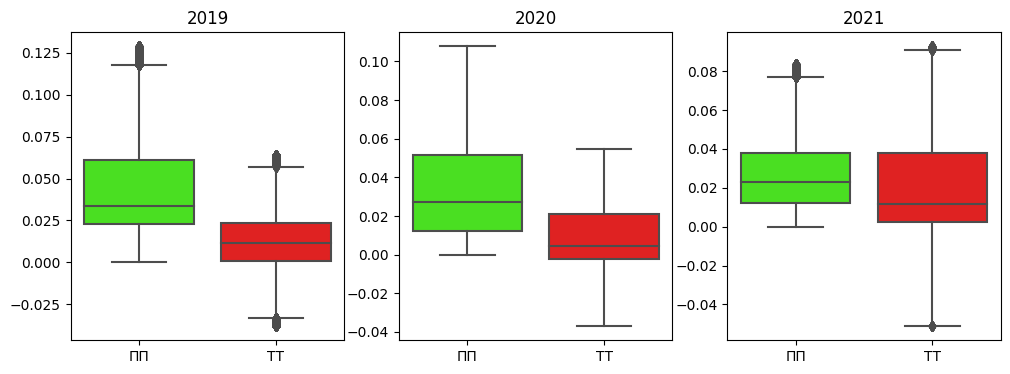

In [4]:


fig, axes = plt.subplots(1,3, figsize=(12,4)) 


my_pal = {"ПП": "#38FF02", "ТТ": "#FF0202"}


sns.boxplot(data = general_df , x = 'type', y = '2019',palette = my_pal, ax = axes[0])
axes[0].set(title = '2019', xlabel = '',ylabel = '' )


sns.boxplot(data = general_df , x = 'type', y = '2020',palette = my_pal, ax = axes[1])
axes[1].set(title = '2020', xlabel = '',ylabel = '' )


sns.boxplot(data = general_df , x = 'type', y = '2021',palette = my_pal, ax = axes[2])
axes[2].set(title = '2021', xlabel = '',ylabel = '' )



general_df.groupby(['type']).describe()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


general_df = general_df.sample(10000)

X = general_df[['2019','2020','2021']].values
y = general_df['type'].values.reshape(-1,1)

y[y == 'ТТ'] = 0
y[y == 'ПП'] = 1


y = y.astype(int)

x_train, x_test, y_train, y_test = train_test_split(X , y,test_size = 0.2, random_state=13)

In [6]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_test, y_test, cv=10).mean()

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      9936
           1       0.88      0.79      0.84     10064

    accuracy                           0.84     20000
   macro avg       0.85      0.84      0.84     20000
weighted avg       0.85      0.84      0.84     20000



0.83905

In [7]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(x_train, y_train)
predictions = neigh.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      9936
           1       0.90      0.92      0.91     10064

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



0.8430000000000002

In [8]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      9936
           1       0.91      0.90      0.90     10064

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



0.9005999999999998

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      9936
           1       0.92      0.94      0.93     10064

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



0.9264750000000002

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
cross_val_score(clf, x_train, y_train, cv=10).mean()

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      9936
           1       0.88      0.95      0.91     10064

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



0.908175

# самый лучший рендом форест 

In [8]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(x_train, y_train)

def mapping(raster, vector):
    meta_data = raster.meta
    CRS = raster.crs
    meta_data['count'] = 1
    meta_data['dtype'] = 'float64'

    dir = 'raster_data/classified.tif'

    raster_shape = raster.shape
    data = raster.read().reshape(3,-1).T

    data = np.nan_to_num(data, copy=True, nan=0.0, posinf=None, neginf=None)

    proba_data = RFC.predict_proba(data)[:,1]
    proba_data = proba_data.reshape(raster_shape)
    new_dataset = rasterio.open(dir, 'w', **meta_data)
    new_dataset.write(proba_data, 1)
    new_dataset.close()

    vector_reproj = vector.to_crs(CRS)

    classified_data = rasterio.open(dir, 'r')


    masked_raster, affine__ = mask(classified_data ,vector_reproj.geometry, invert= False)
    new_dataset = rasterio.open(dir, 'w', **meta_data)
    new_dataset.write(masked_raster)
    new_dataset.close()


In [9]:
agriculture = gpd.read_file('vector_data/agriculture.geojson')
agriculture = agriculture.to_crs("EPSG:32638")
main_raster = rasterio.open("raster_data/RGB_minNDTI.tif", 'r') 


In [10]:

mapping(main_raster, agriculture )

In [ ]:
# оставляем так, это уже повеселее выглядит